In [1]:
import os, sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# modelica interface
import buildingspy.simulate.Simulator as si
import buildingspy.io.outputfile as buipy_io

# thermal
import  CoolProp.CoolProp as CP
from CoolProp.HumidAirProp import HAPropsSI
import psychrolib as psylib
psylib.SetUnitSystem(psylib.SI)

In [2]:
sys.path.insert(0, os.path.join('../..', 'calibration'))
from thermodynamics import *

import media_model_mgcl2 as model_mg
import media_model_water as model_w

In [3]:
def readResults(path, mat_name):
    res = buipy_io.Reader(path + "/{}.mat".format(mat_name), "dymola")
    return res

# Read mat-file

In [4]:
result_abs_ste = readResults('./results_data/', 'LiCl_Chen_2016_Dehumdification_cc_50')

In [5]:
results_abs_ste_dc = readResults('./results_data/', 'LiCl_Chen_2016_Dehumdification_dc_50')

In [6]:
result_abs_dyn = readResults('./results_data/', 'Absorber_cycle_10000s')

In [10]:
result45 = readResults('./results_data/', 'Regenerator_cycle_45C')
result60 = readResults('./results_data/', 'Regenerator_cycle_60C')

# Absorber

## steady state analysis

In [69]:
def read_vol_T(mat_file, path = './results_data/', medium = 'air'):
    sim_result = readResults(path, mat_file)
    n_seg = int(sim_result.values('abs.nSeg')[1][-1])
    li_T = []
    for i in range(n_seg):
        key = 'abs.vol_{}[{}, 1].T'.format(medium, i + 1)
        T = sim_result.values('{}'.format(key))[1][-1]
        li_T.append(T)
    return li_T

In [70]:
def read_vol_x(mat_file, path = './results_data/', medium = 'air'):
    sim_result = readResults(path, mat_file)
    n_seg = int(sim_result.values('abs.nSeg')[1][-1])
    li_x = []
    for i in range(n_seg):
        key = 'abs.vol_{}[{}, 1].X[1]'.format(medium, i + 1)
        x = sim_result.values('{}'.format(key))[1][-1]
        li_x.append(x)
    return li_x

### counter current

In [71]:
T_cc_air = read_vol_T('LiCl_Chen_2016_Dehumdification_cc_50')
T_cc_abs = read_vol_T('LiCl_Chen_2016_Dehumdification_cc_50', medium='abs')
x_cc_air = read_vol_x('LiCl_Chen_2016_Dehumdification_cc_50')

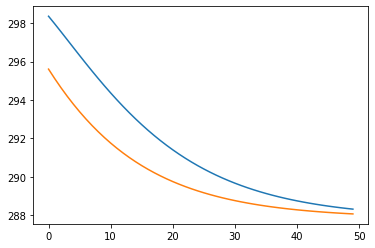

In [77]:
plt.plot(range(len(T_cc_air)), T_cc_air, T_cc_abs[::-1])

### direct current

In [78]:
T_dc_air = read_vol_T('LiCl_Chen_2016_Dehumdification_dc_50')
T_dc_abs = read_vol_T('LiCl_Chen_2016_Dehumdification_dc_50', medium='abs')
x_dc_air = read_vol_x('LiCl_Chen_2016_Dehumdification_dc_50')

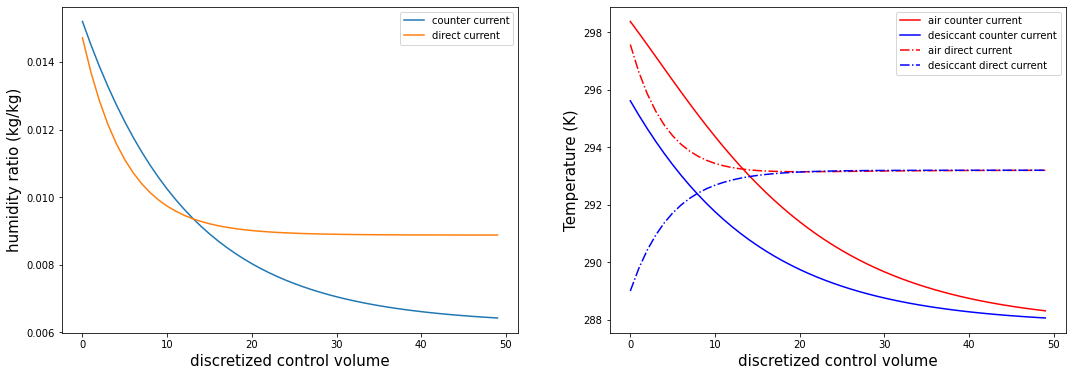

In [102]:
fig, ax = plt.subplots(1,2, figsize = [18,6])
ax[0].plot(range(len(x_cc_air)), x_cc_air, label = 'counter current')
ax[0].plot(range(len(x_dc_air)), x_dc_air, label = 'direct current')

ax[0].set_xlabel('discretized control volume', fontsize = 15)
ax[0].set_ylabel('humidity ratio (kg/kg)', fontsize = 15)

ax[1].plot(range(len(T_cc_air)), T_cc_air, color = 'red', linestyle = '-', label = 'air counter current')
ax[1].plot(range(len(T_cc_air)), T_cc_abs[::-1], color = 'blue', linestyle = '-', label = 'desiccant counter current')

ax[1].plot(range(len(T_dc_air)), T_dc_air, color = 'red', linestyle = '-.', label = 'air direct current')
ax[1].plot(range(len(T_dc_air)), T_dc_abs, color = 'blue', linestyle = '-.', label = 'desiccant direct current')

ax[1].set_xlabel('discretized control volume', fontsize = 15)
ax[1].set_ylabel('Temperature (K)', fontsize = 15)

ax[0].legend()
ax[1].legend()

## Dynamic analysis

In [12]:
T_des_cooler_input = result_abs_dyn.values('Cooler_input.y')

In [13]:
T_air_in = result_abs_dyn.values('Absorber.air_in.T')
T_air_out = result_abs_dyn.values('Absorber.air_out.T')

In [14]:
T_air_out

(array([0.000e+00, 2.000e+00, 4.000e+00, ..., 9.998e+03, 1.000e+04,
        1.000e+04], dtype=float32),
 array([303.15   , 291.11826, 291.11752, ..., 299.42532, 299.4253 ,
        299.4253 ], dtype=float32))

In [15]:
x_air_in = result_abs_dyn.values('Absorber.air_in.X[1]')

In [16]:
x_air_out = result_abs_dyn.values('Absorber.air_out.X[1]')

In [17]:
xi_des_conc_in = result_abs_dyn.values('X_s')
# series_des_conc_in[0] = np.array([0., 10000.])

xi_des_conc_out = result_abs_dyn.values('DesContainer.X[2]')

In [19]:
T_des_cooler_input[0]

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 9.998e+03, 1.000e+04,
       1.000e+04], dtype=float32)

In [20]:
T_des_cooler_input[1]

array([288.15, 288.15, 288.15, ..., 298.15, 298.15, 298.15], dtype=float32)

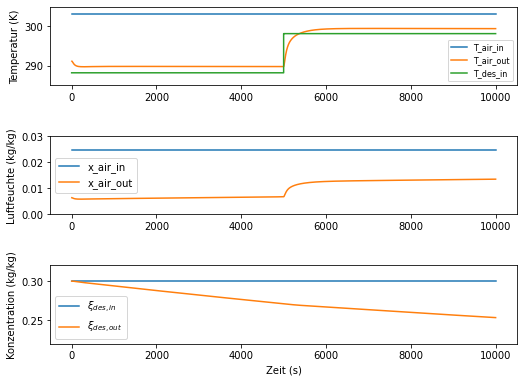

In [18]:
fig, axs = plt.subplots(3,1, figsize = (8,6))

axs[0].plot(T_air_in[0], T_air_in[1], label = 'T_air_in')
axs[0].plot(T_air_out[0][3:], T_air_out[1][3:], label = 'T_air_out')
axs[0].plot(T_des_cooler_input[0], T_des_cooler_input[1], label='T_des_in')
axs[0].set_ylim([285, 305])
axs[0].set_ylabel('Temperatur (K)')
         
axs[1].plot(x_air_in[0], x_air_in[1], label = 'x_air_in')
axs[1].plot(x_air_out[0][2:], x_air_out[1][2:], label = 'x_air_out')
axs[1].set_ylim([0, 0.03])
axs[1].set_ylabel('Luftfeuchte (kg/kg)')

axs[2].plot(xi_des_conc_in[0], xi_des_conc_in[1], label = r'$\xi_{des,in}$')
axs[2].plot(xi_des_conc_out[0], xi_des_conc_out[1], label = r'$\xi_{des,out}$')
axs[2].set_ylim([0.22, 0.32])
axs[2].set_ylabel('Konzentration (kg/kg)')

axs[2].set_xlabel("Zeit (s)")

axs[0].legend(fontsize = 8)
axs[1].legend()
axs[2].legend()
fig.tight_layout(pad=3.0)

plt.savefig("absorber_change.png")

# Desorber

In [6]:
xi_des_out_45 = result45.values('DesContainer.X[2]')
xi_des_out_60 = result60.values('DesContainer.X[2]')

In [25]:
x_air_in = result45.values('Regenerator.air_in.X[1]')

x_air_out_45 = result45.values('Regenerator.air_out.X[1]')

x_air_out_60 = result60.values('Regenerator.air_out.X[1]')

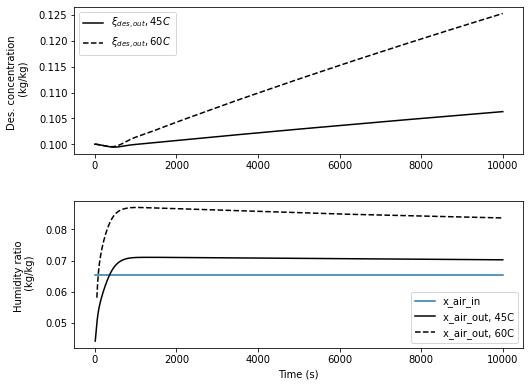

In [34]:
fig, axs = plt.subplots(2,1, figsize = (8,6))

# ax2 = ax1.twinx()

axs[0].plot(xi_des_out_45[0], xi_des_out_45[1], linestyle = '-', color= '000000', label = r'$\xi_{des,out}, 45C$')
axs[0].plot(xi_des_out_60[0], xi_des_out_60[1], linestyle = '--', color= '000000', label = r'$\xi_{des,out}, 60C$')

axs[1].plot(x_air_in[0], x_air_in[1], label = 'x_air_in')
axs[1].plot(x_air_out_45[0][5:], x_air_out_45[1][5:], label = 'x_air_out, 45C', linestyle = '-', color= '000000')
axs[1].plot(x_air_out_60[0][5:], x_air_out_60[1][5:], label = 'x_air_out, 60C', linestyle = '--', color= '000000')

axs[0].set_ylabel('Des. concentration \n (kg/kg)', fontsize=10, labelpad = 10)

axs[1].set_ylabel('Humidity ratio \n (kg/kg)', fontsize=10, labelpad = 10)
axs[1].set_xlabel('Time (s)', fontsize=10)

axs[0].legend()
axs[1].legend()

fig.tight_layout(pad=3.0)
plt.savefig("regenerator_change.png")